# Predicting Heart Disease

#### The World Health Organization (WHO) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

#### There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

#### We are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

#### We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. 

In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier 

In [51]:
heart = pd.read_csv('heart.csv')
print(heart.head(5))
print(heart.shape)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
(918, 12)


## 1. Exploratory Data Analysis

#### Average age in the dataset is 53.5 years old. There are no null values. There are a few outliers. The min values for RestingBP column is 0 bps indicating that a misreading was recorded or that the patient was already dead. A Cholesterol value of 0 mm/dl is also unlikely due to be calculated by "adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level." These datapoints have no use for the study and will need to be eliminated. Also for the Cholesterol column the max value is far above the 75% percentile. The Cholesterol column's median value is 25 mm/dl higher than the mean indicating that the distribution is left-skewed.

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


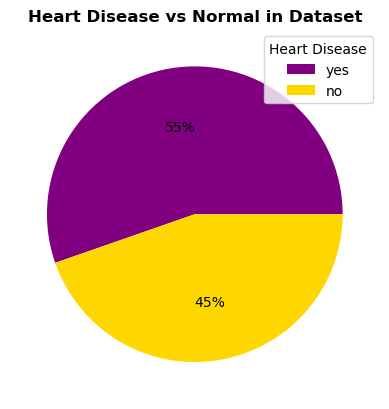

In [52]:
print(heart.describe())

heart['HeartDisease'].value_counts(normalize=True).plot.pie(labeldistance=None, autopct='%1.0f%%', colors=['purple', 'gold'])
plt.title('Heart Disease vs Normal in Dataset', weight='bold')
plt.ylabel('')
plt.legend(labels=['yes','no'], title='Heart Disease', fancybox=True)

Text(0.5, 1.0, 'Distribution of Heart Disease by Age')

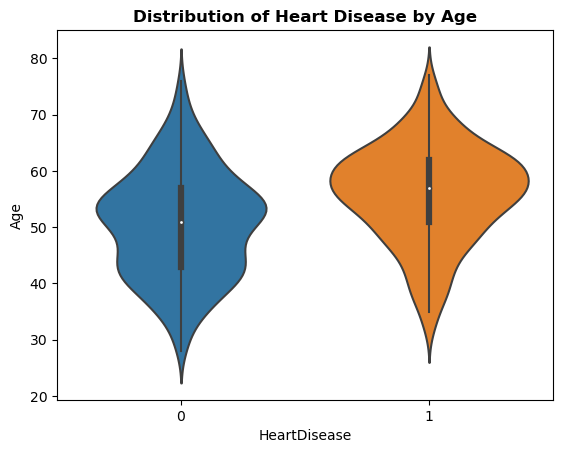

In [53]:
sns.violinplot(data=heart, x='HeartDisease', y='Age', split=True)
plt.title('Distribution of Heart Disease by Age', weight='bold')

Text(0.5, 1.0, 'Distribution of Heart Disease by Age/Gender')

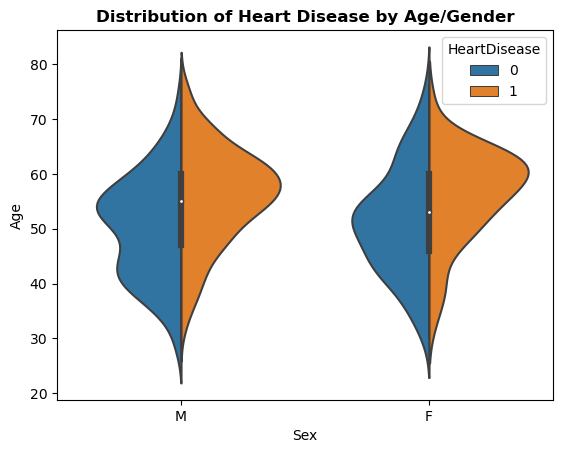

In [54]:
sns.violinplot(data=heart, x='Sex', y='Age', hue = 'HeartDisease', split=True)
plt.title('Distribution of Heart Disease by Age/Gender', weight='bold')

Text(0.5, 0, '')

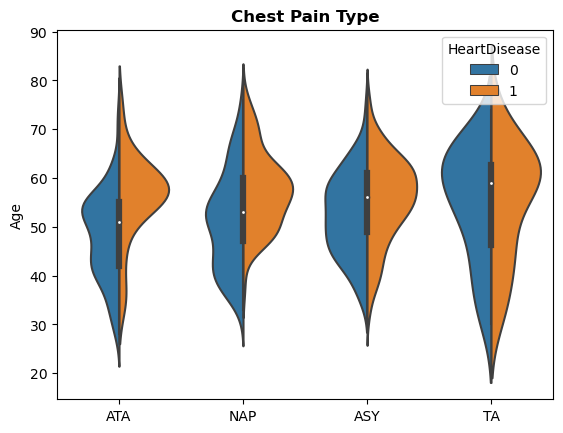

In [55]:
sns.violinplot(data=heart, x='ChestPainType', y='Age', hue='HeartDisease', split=True)
plt.title('Chest Pain Type', weight='bold')
plt.xlabel('')

In [56]:
print(heart.dtypes)

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


#### Let us observe the following:

#####  - It looks like the average age of patients is 53 years old. 
#####  -  The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
#####  -  RestingBP and Cholesterol have a minimum value of zero.
#####  -  There don't seem to be any missing values in these columns.

#### This is where domain expertise can help us. Since we might not be suited to answer the question, we could reach out to a subject matter expert or research it on our own.

####  As per the dataset description, Cholesterol contains the serum cholesterol values. And per the American Heart Association, serum cholesterol:

##### "is a composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level"

#### The above information is enough to let us know that a 0 value for serum cholesterol is unlikely.

#### So how do these insights help us with our prediction model? We'll come back to this later. For now, we'll continue exploring our dataset.

#### Our observations so far were only for a subset of the columns. Additionally, we don't know how the dataset is distributed in relation to our target variable -- HeartDisease. For example, how many patients had a resting ECG categorized as ST? How many female patients had heart disease?

#### We'll explore the categorical features next, but we'll rely on creating visualizations to understand how the data is distributed.

## 2: Visualizations
#### Let us explore the number of missing values

In [57]:
heart[heart.isna() == False]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


#### This returns the same size as given by our former description. This means that tehre is no missing values. 

#### For every categorical column in the dataset, including HeartDisease and FastingBS:

##### - Create a bar chart that displays the number of rows for each category of that column.
##### - Add appropriate axis labels, data labels and a title to each plot.
##### - In a markdown cell, briefly summarize any relevant insight that you gather from the plots. For example, how many patients are male and how many are female?

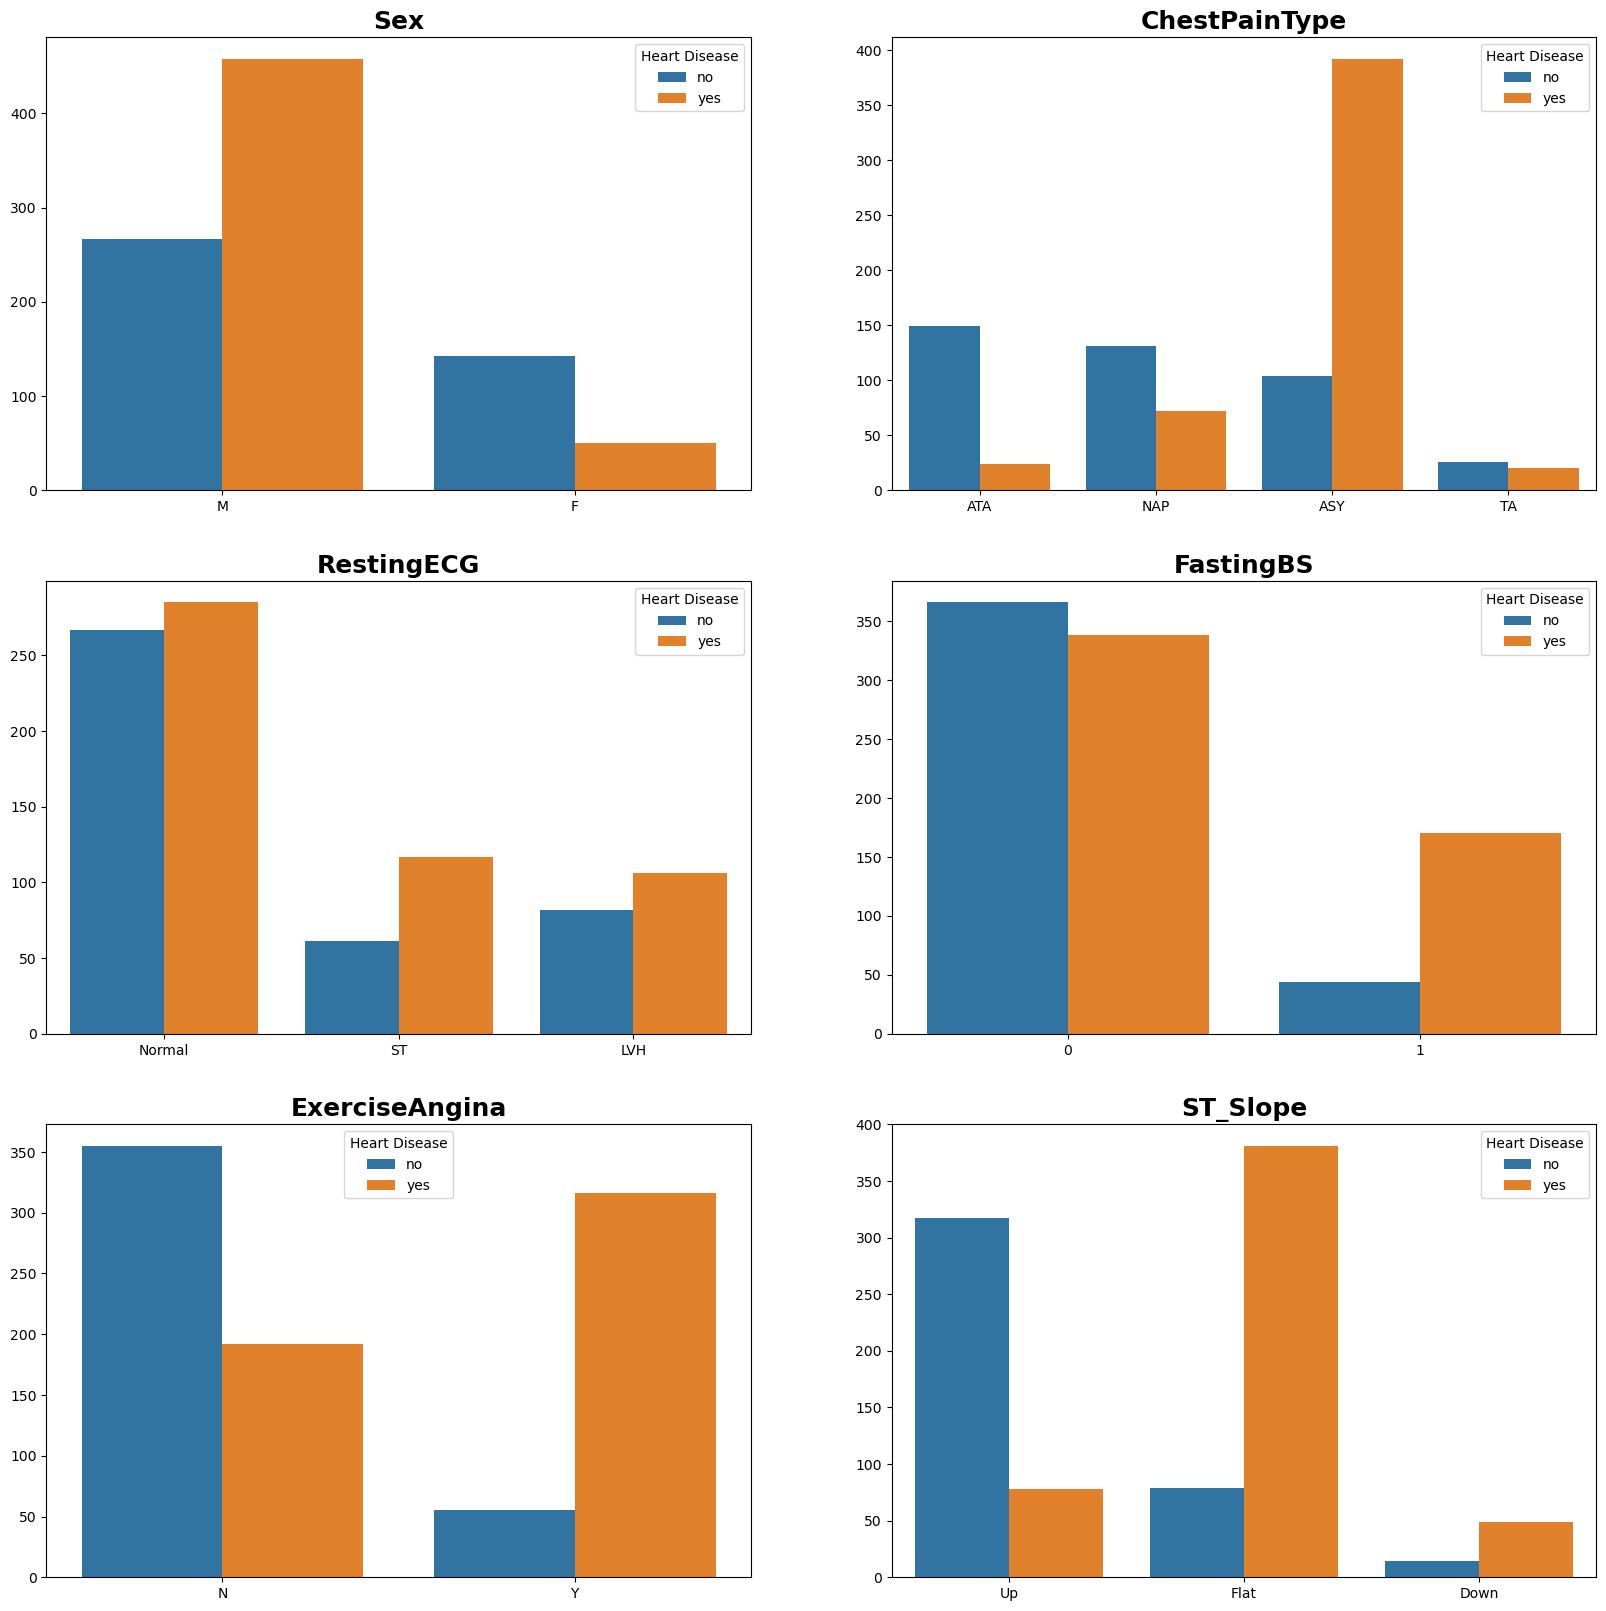

In [58]:
# we create a list with the catergorical columns
categorical = ['Sex', 'ChestPainType', 'RestingECG', 'FastingBS', 'ExerciseAngina', 'ST_Slope']

plt.figure(figsize=(20,20))
for i, cat in enumerate(categorical):
    plt.subplot(3,2,i+1)
    sns.countplot(data=heart, x=cat, hue='HeartDisease')
    plt.title(cat, weight='bold', size=18)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(labels=['no', 'yes'], title='Heart Disease', fancybox=True)
plt.show()


## 3. Data Cleaning

#### We see that, while there is a unique entry #449 with a resting BP of zero, there are 172 entries that have zero cholesterol! We also note that #449 is included into the second group.

In [69]:
 zero_bp = heart[heart['RestingBP']==0].shape[0]
print('How many entries with 0 resting BP?', zero_bp)

How many entries with 0 resting BP? 1


In [70]:
 zero_cholesterol = heart[heart['Cholesterol']==0].shape[0]
print('How many entries with 0 cholesterol?', zero_cholesterol)

How many entries with 0 cholesterol? 172


#### WE can choose to simply ignore those values, or even replace them with the class average. 

#### However, we hope to perform something a bit more sophisticated: We are going to attempt to remove these 0 value readings by eliminating the outliers in columns with numerical values. The criteria for determining what datapoints are outliers will be by going off of standard deviations. Any datapoint outside of three standard deviations will be removed.



In [71]:
stds = 3

# We fix the strictly numerical columns
columns_to_fix = ['Age','RestingBP','Cholesterol','MaxHR', 'Oldpeak']

fixed_heart=heart.copy()[heart[columns_to_fix].apply(lambda x: np.abs(x - x.mean()) / x.std() < stds)
   .all(axis=1)]

fixed_heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,53.497219,132.027809,198.005562,0.232481,136.917686,0.861513,0.547275
std,9.456073,17.120895,107.157779,0.422649,25.356740,1.007626,0.498037
min,28.000000,80.000000,0.000000,0.000000,63.000000,-2.000000,0.000000
25%,47.000000,120.000000,174.500000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,222.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.000000,266.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,185.000000,518.000000,1.000000,202.000000,4.000000,1.000000


In [72]:
print(round(fixed_heart.shape[0]/heart.shape[0] * 100), '% were within three standard deviations')

98 % were within three standard deviations


In [73]:
print(round(fixed_heart[fixed_heart['Cholesterol']==0].shape[0] / fixed_heart.shape[0]*100), '% still have 0 cholesterol')

19 % still have 0 cholesterol


#### Outliers have been removed from the dataset. Unfortunately, there are still readings of 0 mm/dl cholesterol which is unlikely to be possible. It is unknown if these readings are due to null values being recorded as 0 in the dataset or other human error. Dropping patient data with these readings would eliminate 18.58% of the dataset and such a loss in datapoints may skew the results too much. The 0 mm/dl cholesterol readings will be replaced by the mean of the non-zero results.

In [74]:
non_zero_cholesterol=fixed_heart[fixed_heart['Cholesterol']!=0]
mean_non_zero=non_zero_cholesterol['Cholesterol'].mean()
fixed_heart['Cholesterol']=fixed_heart['Cholesterol'].replace(0, mean_non_zero)


fixed_heart['Cholesterol'].describe()

count    899.000000
mean     243.178962
std       50.281652
min       85.000000
25%      214.000000
50%      243.178962
75%      266.000000
max      518.000000
Name: Cholesterol, dtype: float64

#### Cholesterol readings of 0 mm/dl have been removed from dataset. Next, the process of removing any remaining outliers outside of three standard deviations will removed.



In [75]:
fixed_heart=fixed_heart[fixed_heart[columns_to_fix].apply(lambda x: np.abs(x - x.mean()) / x.std() < stds)
   .all(axis=1)]

fixed_heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,53.426136,131.942045,241.025601,0.232955,137.055682,0.838409,0.544318
std,9.466377,17.024644,45.418842,0.422954,25.338668,0.974161,0.498315
min,28.000000,92.000000,100.000000,0.000000,63.000000,-2.000000,0.000000
25%,47.000000,120.000000,213.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,243.178962,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.000000,264.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,180.000000,394.000000,1.000000,202.000000,3.800000,1.000000


In [76]:
percent_remaining=fixed_heart.shape[0]/heart.shape[0]*100
print(f"{percent_remaining:.2f}% were within the three standard deviations")

95.86% were within the three standard deviations


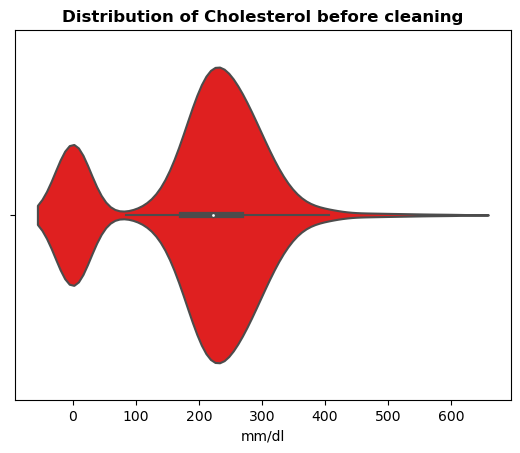

Text(0.5, 0, 'mm/dl')

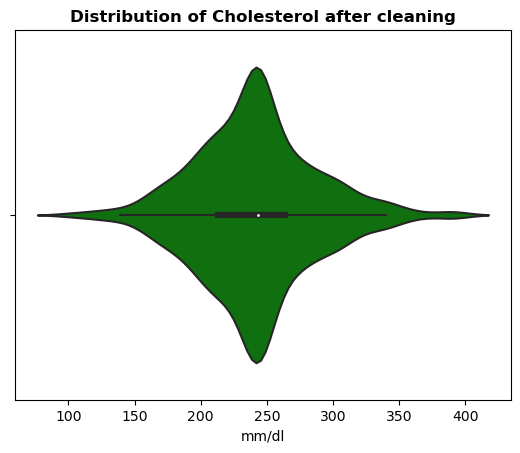

In [77]:
sns.violinplot(data=heart, x="Cholesterol", color='red')
plt.title('Distribution of Cholesterol before cleaning', weight='bold')
plt.xlabel('mm/dl')
plt.show()
sns.violinplot(data=fixed_heart, x="Cholesterol", color='green')
plt.title('Distribution of Cholesterol after cleaning', weight='bold')
plt.xlabel('mm/dl')

#### After replacing 0 mm/dl cholesterol results with the mean of the non-zero results and then once again going through the process of removing outliers. The cleaned dataset still has over 95% of the original datapoints. Losing less than 5% of the data is an acceptable loss under the circumstances.



## 4. Feature Selection
#### Need to select features for the predictive model. First will need to convert catagorical columns into dummy variables. Afterwards, a Pearson's correlation heatmap will be generated to determine what the top six features that correlate to heart disease in the dataset.

In [80]:
fixed_heart=pd.get_dummies(data=fixed_heart, drop_first=True)
print(fixed_heart.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 917
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                880 non-null    int64  
 1   RestingBP          880 non-null    int64  
 2   Cholesterol        880 non-null    float64
 3   FastingBS          880 non-null    int64  
 4   MaxHR              880 non-null    int64  
 5   Oldpeak            880 non-null    float64
 6   HeartDisease       880 non-null    int64  
 7   Sex_M              880 non-null    uint8  
 8   ChestPainType_ATA  880 non-null    uint8  
 9   ChestPainType_NAP  880 non-null    uint8  
 10  ChestPainType_TA   880 non-null    uint8  
 11  RestingECG_Normal  880 non-null    uint8  
 12  RestingECG_ST      880 non-null    uint8  
 13  ExerciseAngina_Y   880 non-null    uint8  
 14  ST_Slope_Flat      880 non-null    uint8  
 15  ST_Slope_Up        880 non-null    uint8  
dtypes: float64(2), int64(5), u

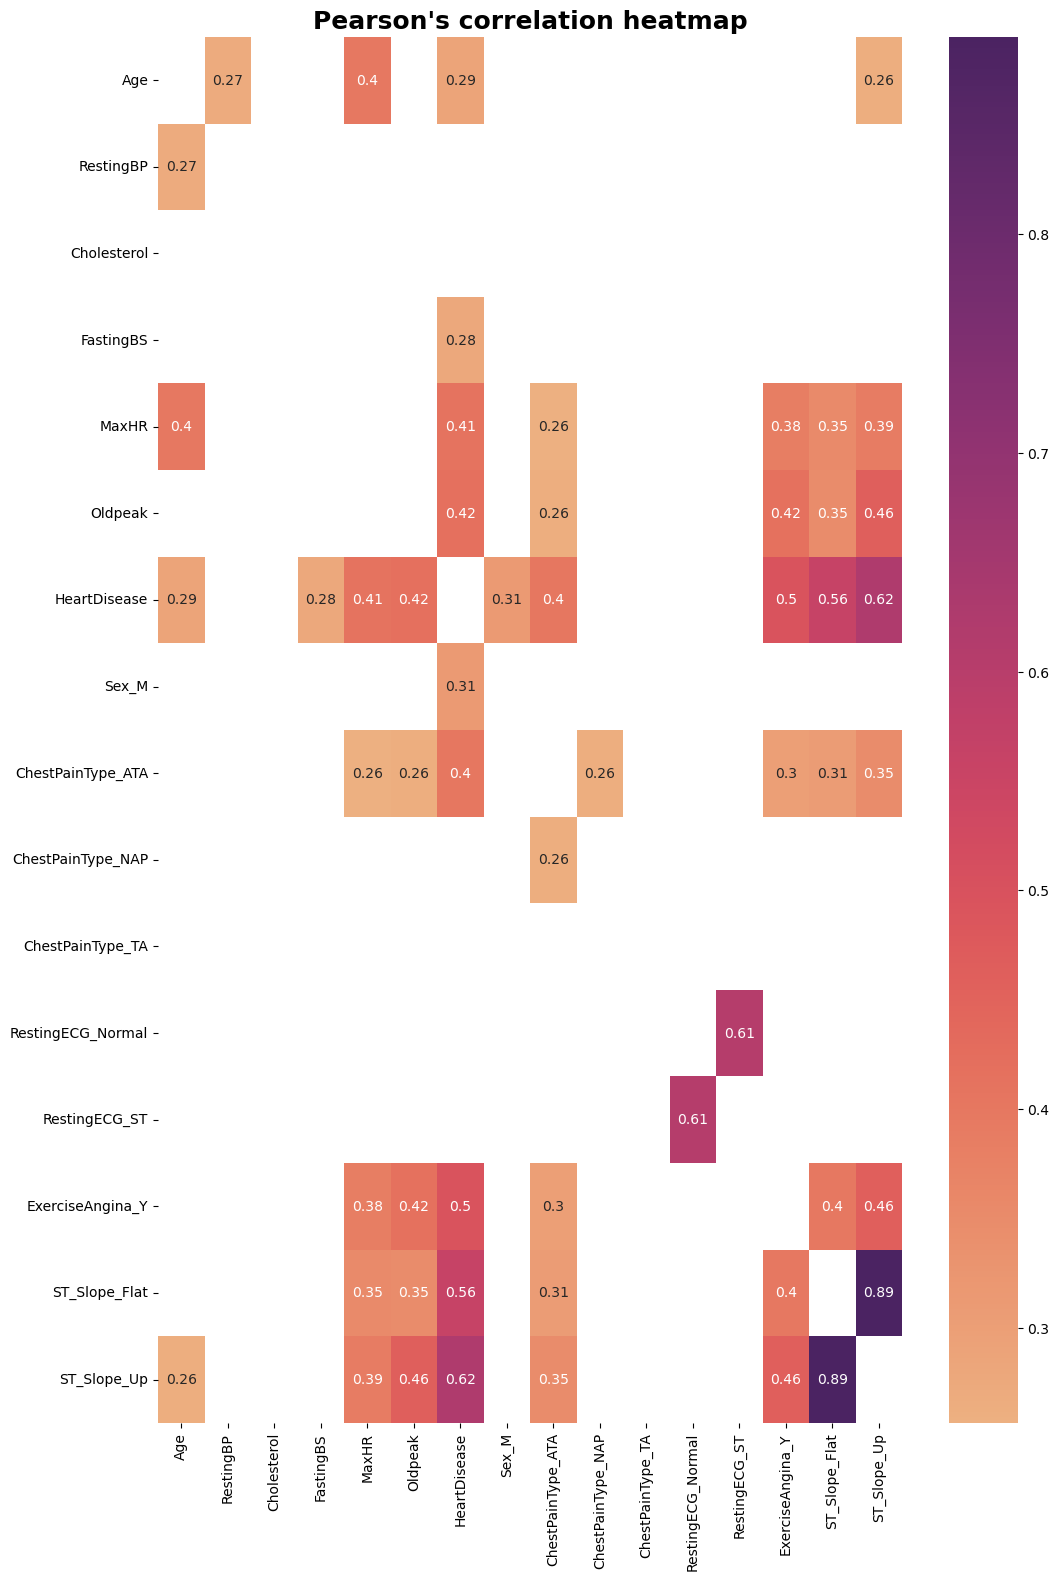

In [94]:
# we caclulate the correlations and turn them into absolute values
correlations = abs(fixed_heart.corr())

#let's create a heat map for high correlations only, to reduce overcrowding and enhance readability
plt.figure(figsize=(12,18))
heat_map = sns.heatmap(correlations[(correlations>0.25)&(correlations<1)], cmap='flare', annot=True)
plt.title("Pearson's correlation heatmap", weight='bold', size=18);

In [100]:
top_6_features = list(correlations['HeartDisease'].sort_values(ascending=False)[1:7].index)
top_6_features

['ST_Slope_Up',
 'ST_Slope_Flat',
 'ExerciseAngina_Y',
 'Oldpeak',
 'MaxHR',
 'ChestPainType_ATA']

#### Top six features correlating to heart disease are below:

##### - ST_Slope_Up (upward slope of the peak exercise ST segment)
##### - ST_Slope_Flat (flat slope of the peak exercise ST segment)
##### - ExerciseAngina_Y (has exercise-induced angina)
##### - Oldpeak (ST depression induced by exercise relative to rest)
##### - MaxHR (Maximum Heart Rate)
##### - Chest PainType_ATA (Atypical Chest Pain)

## 5. Building a Classifier I
#### Train KNeighborsClassifier models with one of the top six features one at a time and then compare the results.

In [102]:
# First we split the data set

X=fixed_heart.drop(columns='HeartDisease')
y=fixed_heart['HeartDisease']

#### First goal is to determine the optimal test size. For now, the average results of the top six features will be determined and the only variable will be various test sizes. The criteria is the highest average possible while keeping the test size as small as possible.



<AxesSubplot:title={'center':'Average Accuracy of Top Six Features with Different Test Size'}>

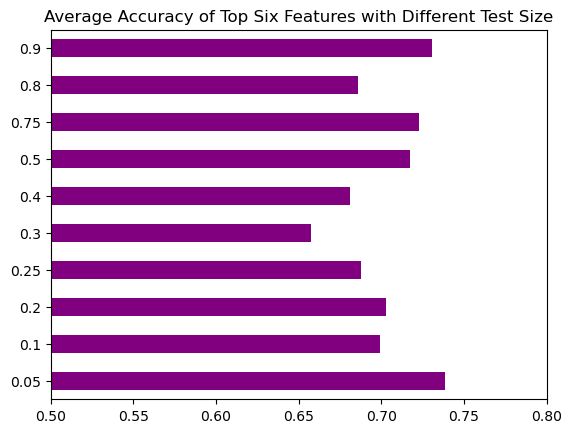

In [118]:
test_size=[0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.8, 0.9]

average_accuracy={}

for size in test_size:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=size, random_state = 50) 
    results=[]
    for feat in top_6_features:
        # results=[]
        knn=KNeighborsClassifier(n_neighbors=10)
        knn.fit(X_train[[feat]], y_train)
        results.append(knn.score(X_val[[feat]], y_val))
    average_accuracy[size]=sum(results)/len(results)    

average_accuracy_df=pd.DataFrame.from_dict(average_accuracy,orient='index')
average_accuracy_df.plot.barh(title='Average Accuracy of Top Six Features with Different Test Size', color='purple', legend=False,xlim=(0.5,0.8)) 

#### A test size of 0.25 is the second highest average accuracy just behind 0.9. Choosing 0.9 test size (90%) is not accepable so 0.25 is what will be used. Oddly there is a drop in the average accuracy at 0.3 and 0.4. Next will check different random states to see if this pattern repeats.



<AxesSubplot:title={'center':'Accuracy of Top Six Features'}>

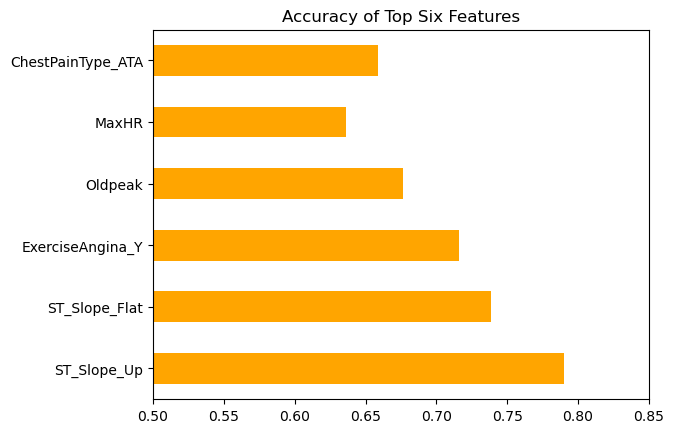

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 50)

neighbor=10
accuracies={}

for feat in top_6_features:
    knn=KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train[[feat]], y_train)
    accuracies[feat]=knn.score(X_val[[feat]], y_val)  
    
accuracies_df=pd.DataFrame.from_dict(accuracies,orient='index')
accuracies_df.plot.barh(xlim=(0.5,0.85), title='Accuracy of Top Six Features', color='orange', legend=False)

## 6. Building a Classifier II
#### Next, a model using all six features at once. The scales of the individual features are different for example a few of them can only be a one or zero while others such as MaxHR can have far higher values. First will need to normalize all the features so they can work together.

In [121]:
X_train, X_val, y_train, y_val = train_test_split(X[top_6_features], y, test_size=0.2, random_state=50)

scaler=MinMaxScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.transform(X_val)

knn=KNeighborsClassifier(n_neighbors=neighbor)
knn.fit(X_train_scaled, y_train)
accuracy=knn.score(X_val_scaled, y_val)

print(f'Accuracy of model is {accuracy*100:.2f}%')

Accuracy of model is 80.11%


## 7. Hyperparameter Tuning
#### GridSearchCV will be used to determine the optimal parameters that will be used for testing the test set.

In [122]:
# Split dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X[top_6_features], y, test_size=0.2, random_state=417)

scaler=MinMaxScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# parameters that will be tested
grid_params = {"n_neighbors": range(5, 30),
                "metric": ["minkowski", "manhattan"],
              'weights': ['uniform','distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(5, 30),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [123]:
best_score=knn_grid.best_score_
best_params=knn_grid.best_params_

print(f'best score obtained was {best_score*100:0.2f}% with {best_params}')

best score obtained was 82.53% with {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}


#### Optimal paramaters:

##### - algorithm - 'ball_tree'
##### - metric - 'manhattan'
##### - n_neighbors - '23'
##### - weights - 'uniform'

## 8. Model Evaluation on Test Set
#### Finally, use the optimal parameters to evaluate the test set.



In [126]:
knn = KNeighborsClassifier(n_neighbors=23, metric='manhattan', algorithm='ball_tree', weights='uniform')
knn.fit(X_train_scaled, y_train)

accuracy=knn_grid.best_estimator_.score(X_test_scaled, y_test)
print(f'Test score obtained was {accuracy*100:0.2f}%')

Test score obtained was 84.66%


#### The model was able to obtain an accuracy of 84.66% using the optimal parameters and test size. Much of the features used in this model would be fairly common sense indicators of heart disease even without using predictive models of extensive medical training. Symptoms such as abnormally high heart rate or having pain in chest during exercise are fairly obvious indications of an unhealthy heart.

#### That said, modeling the data and having a fairly good success rate at predicting heart disease (over 80%) can be useful for determining what symptoms indicate the need for further testing to prevent advanced heart disease. Resources are limited and using data models to determine which patients are higher priority for testing/treatment based off of symptoms that corrolate highest for heart disease/failure is critical for maximizing limited resources.